In [1]:
import sys, os
os.getcwd()

'/Users/arindam/Machine Learning/GenAI_2025/AgenticAI/9_Automated-Research-Report-Generation'

In [2]:
# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: /Users/arindam/Machine Learning/GenAI_2025


In [3]:
from research_and_analyst.utils.model_loader import ModelLoader

In [4]:
model_loader = ModelLoader()

{"timestamp": "2025-11-10T02:45:10.074051Z", "level": "info", "event": "Initializing ApiKeyManager"}
{"timestamp": "2025-11-10T02:45:10.074387Z", "level": "info", "event": "OPENAI_API_KEY loaded successfully from environment"}
{"timestamp": "2025-11-10T02:45:10.074666Z", "level": "info", "event": "GOOGLE_API_KEY loaded successfully from environment"}
{"timestamp": "2025-11-10T02:45:10.075043Z", "level": "info", "event": "GROQ_API_KEY loaded successfully from environment"}
{"path": "/Users/arindam/Machine Learning/GenAI_2025/AgenticAI/9_Automated-Research-Report-Generation/research_and_analyst/config/configuration.yaml", "keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-11-10T02:45:10.076547Z", "level": "info", "event": "Configuration loaded successfully"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-11-10T02:45:10.076732Z", "level": "info", "event": "YAML configuration loaded successfully"}


In [5]:
llm=model_loader.load_llm()

{"provider_key": "openai", "timestamp": "2025-11-10T02:45:10.079987Z", "level": "info", "event": "LLM Provider Selected"}
{"provider": "openai", "model": "gpt-5-nano", "timestamp": "2025-11-10T02:45:10.080319Z", "level": "info", "event": "Loading LLM"}
{"provider": "openai", "model": "gpt-5-nano", "timestamp": "2025-11-10T02:45:10.222938Z", "level": "info", "event": "LLM loaded successfully"}


In [6]:
llm.invoke("hi").content

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Hi! Nice to meet you. What would you like help with today? I can explain ideas, answer questions, brainstorm, draft text, help with coding, summarize content, plan things, or just chat. Tell me what you’re aiming for, or ask me anything.'

In [7]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [8]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [9]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [10]:
analyst = Analyst(
    name="Arindam Choudhury",
    role="genai eng",
    affiliation="Personal AI Research LAB",
    description="I am genai developer as well as mentor"
    )

In [11]:
print(analyst.name)
print(analyst.role)
print(analyst.affiliation)

Arindam Choudhury
genai eng
Personal AI Research LAB


In [12]:
print(analyst.persona)

Name: Arindam Choudhury
Role: genai eng
Affiliation: Personal AI Research LAB
Description: I am genai developer as well as mentor



In [13]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [14]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    

In [15]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [16]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [17]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


In [18]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)] + [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}
    

In [19]:
create_analyst(
    {'topic': 'Sales Agent',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Jordan Park', role='Senior Sales Enablement & Performance Analytics Lead', affiliation='MarketEdge Analytics', description='Theme: Sales process optimization and technology enablement. Focuses on designing efficient sales workflows, coaching and training programs, KPI design and dashboards, CRM/tooling adoption, and measuring ROI of enablement initiatives. Aims to shorten ramp time, improve win rates, and harmonize human skills with AI-assisted selling, while ensuring data quality and user adoption.'),
  Analyst(name='Dr. Maya Chen', role='Ethics & Compliance Analyst for Sales & AI', affiliation='Center for Responsible Sales', description='Theme: Ethics, regulatory compliance, and agent well-being in sales. Examines data privacy and governance (GDPR/CCPA), telemarketing and consent rules (TCPA), call recording and transparency, fair compensation and workload management, burnout risk, and governance of AI usage in sales processes. Develops frameworks for resp

In [20]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [21]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END


In [22]:
# def should_continue(state):
#     """ Return the next node to execute """
#     human_analyst_feedback = state.get("human_analyst_feedback",None)
#     if human_analyst_feedback:
#         return "create_analyst"

In [23]:
from IPython.display import Image, display

## First Workflow

In [24]:
builder = StateGraph(GenerateAnalystsState)

In [25]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [26]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [27]:
memory = MemorySaver()

In [28]:
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

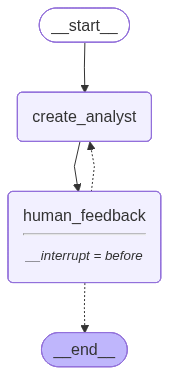

In [29]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [30]:
topic = "the benefits of adopting Langgraph as an agent framework"

In [31]:
max_analysts = 2

In [32]:
thread =  {"configurable":{"thread_id":1}}

In [33]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Maya Chen
Affiliation: LangTech Labs
Role: Senior AI Architecture Analyst (Modularity & Interoperability)
Description: Focuses on how Langgraph enables modular, pluggable agents and cross-domain interoperability. Evaluates component reusability, standardized interfaces, and developer experience. Motives: accelerate prototyping, reduce integration friction, and foster a healthy plugin ecosystem. Key concerns include plugin quality, versioning, security of third‑party components, and interface stability to prevent fragmentation.
--------------------------------------------------
Name: Prof. Luis Nakamura
Affiliation: Center for AI Policy & Safety
Role: Governance & Safety Analyst (Scalability & Observability)
Description: Assesses Langgraph's scalability, multi‑agent coordination, observability, auditability, and policy enforcement in enterprise settings. Focuses on governance, traceability of decisions, reproducibility, and regulatory compliance. Motives: guide safe, auditable

In [34]:
state = graph.get_state(thread)

In [35]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 2, 'analysts': [Analyst(name='Dr. Maya Chen', role='Senior AI Architecture Analyst (Modularity & Interoperability)', affiliation='LangTech Labs', description='Focuses on how Langgraph enables modular, pluggable agents and cross-domain interoperability. Evaluates component reusability, standardized interfaces, and developer experience. Motives: accelerate prototyping, reduce integration friction, and foster a healthy plugin ecosystem. Key concerns include plugin quality, versioning, security of third‑party components, and interface stability to prevent fragmentation.'), Analyst(name='Prof. Luis Nakamura', role='Governance & Safety Analyst (Scalability & Observability)', affiliation='Center for AI Policy & Safety', description="Assesses Langgraph's scalability, multi‑agent coordination, observability, auditability, and policy enforcement in enterprise settings. Focuses on governance

In [36]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 2,
 'analysts': [Analyst(name='Dr. Maya Chen', role='Senior AI Architecture Analyst (Modularity & Interoperability)', affiliation='LangTech Labs', description='Focuses on how Langgraph enables modular, pluggable agents and cross-domain interoperability. Evaluates component reusability, standardized interfaces, and developer experience. Motives: accelerate prototyping, reduce integration friction, and foster a healthy plugin ecosystem. Key concerns include plugin quality, versioning, security of third‑party components, and interface stability to prevent fragmentation.'),
  Analyst(name='Prof. Luis Nakamura', role='Governance & Safety Analyst (Scalability & Observability)', affiliation='Center for AI Policy & Safety', description="Assesses Langgraph's scalability, multi‑agent coordination, observability, auditability, and policy enforcement in enterprise settings. Focuses on governance, traceability of

In [37]:
state.next

('human_feedback',)

In [38]:
# memory.storage

In [39]:
# memory.storage.items()

In [40]:
# import msgpack

# for thread_id, ns_dict in memory.storage.items():
#     print(f"\n Thread ID: {thread_id}")
    
#     # ns_dict = defaultdict(dict, {'': {...}})
#     for ns, ckpts in ns_dict.items():
#         print(f"  Namespace: '{ns}'")
        
#         # ckpts = dict of {checkpoint_id: (packed_values, packed_metadata, parent_id)}
#         for ckpt_id, (packed_values, packed_metadata, parent_id) in ckpts.items():
#             print(f"    Checkpoint ID: {ckpt_id}")
            
#             # Decode msgpack binary
#             values = msgpack.unpackb(packed_values[1], raw=False)
#             meta = msgpack.unpackb(packed_metadata[1], raw=False)
            
#             print(f"    Values keys: {list(values.keys())}")
#             print(f"    Parent ID: {parent_id}")
#             print(f"    Metadata: {meta}")
#             print("-" * 80)


In [41]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0bddf6-2724-643e-8001-876cfc6e274a'}}

In [42]:
graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0bddf6-2787-6a52-8002-3977b59b9e9f'}}

In [43]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Maya Chen
Affiliation: LangTech Labs
Role: Senior AI Architecture Analyst (Modularity & Interoperability)
Description: Focuses on how Langgraph enables modular, pluggable agents and cross-domain interoperability. Evaluates component reusability, standardized interfaces, and developer experience. Motives: accelerate prototyping, reduce integration friction, and foster a healthy plugin ecosystem. Key concerns include plugin quality, versioning, security of third‑party components, and interface stability to prevent fragmentation.
--------------------------------------------------
Name: Prof. Luis Nakamura
Affiliation: Center for AI Policy & Safety
Role: Governance & Safety Analyst (Scalability & Observability)
Description: Assesses Langgraph's scalability, multi‑agent coordination, observability, auditability, and policy enforcement in enterprise settings. Focuses on governance, traceability of decisions, reproducibility, and regulatory compliance. Motives: guide safe, auditable

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Priya Desai
Affiliation: Independent Startup Analyst
Role: Startup Growth & Product Analyst
Description: Focuses on how startups can rapidly adopt Langgraph to prototype and scale AI-agent products. Emphasizes speed-to-value, cost efficiency, modular architectures, and go-to-market considerations. Highlights how Langgraph can support the latest enterprise applications in early-stage deployments (e.g., AI-powered customer support, automated onboarding, and data integration pipelines) to validate product-market fit quickly.
--------------------------------------------------
Name: Alex Kim
Affiliation: Enterprise Tech Advisory Group
Role: Enterprise Architecture & Security Analyst
Description: Assesses enterprise-grade deployment of Langgraph, emphasizing governance, security, compliance, scalability, and production readiness. Analyzes integration with ERP/CRM/ITSM ecosystems, data governance, observability, and multi-tenant concerns. Focuses on the latest enterprise applications—AI

In [44]:
state = graph.get_state(thread)

In [45]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 2, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Priya Desai', role='Startup Growth & Product Analyst', affiliation='Independent Startup Analyst', description='Focuses on how startups can rapidly adopt Langgraph to prototype and scale AI-agent products. Emphasizes speed-to-value, cost efficiency, modular architectures, and go-to-market considerations. Highlights how Langgraph can support the latest enterprise applications in early-stage deployments (e.g., AI-powered customer support, automated onboarding, and data integration pipelines) to validate product-market fit quickly.'), Analyst(name='Alex Kim', role='Enterprise Architecture & Security Analyst', affiliation='Enterprise Tech Advisory Group', description='Assesses enterprise-grade deployment of Langgraph, emphasizing governanc

In [46]:
state.next

('human_feedback',)

In [47]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 2,
 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application',
 'analysts': [Analyst(name='Priya Desai', role='Startup Growth & Product Analyst', affiliation='Independent Startup Analyst', description='Focuses on how startups can rapidly adopt Langgraph to prototype and scale AI-agent products. Emphasizes speed-to-value, cost efficiency, modular architectures, and go-to-market considerations. Highlights how Langgraph can support the latest enterprise applications in early-stage deployments (e.g., AI-powered customer support, automated onboarding, and data integration pipelines) to validate product-market fit quickly.'),
  Analyst(name='Alex Kim', role='Enterprise Architecture & Security Analyst', affiliation='Enterprise Tech Advisory Group', description='Assesses enterprise-grade deployment of Langgraph, emphasizing governance, security, com

In [48]:
# import msgpack

# def get_all_checkpoints(memory, thread_id="1"):
#     """Return all checkpoints in chronological order for a thread."""
#     checkpoints = []
#     ns_dict = memory.storage.get(thread_id, {})
#     if "" not in ns_dict:
#         return []

#     for ckpt_id, (packed_values, packed_meta, parent_id) in ns_dict[""].items():
#         values = msgpack.unpackb(packed_values[1], raw=False)
#         meta = msgpack.unpackb(packed_meta[1], raw=False)
#         checkpoints.append({
#             "id": ckpt_id,
#             "parent": parent_id,
#             "topic": values.get("topic"),
#             "feedback": values.get("human_analyst_feedback"),
#             "analyst_count": len(values.get("analysts", [])),
#             "analysts": [a.model_dump() for a in values.get("analysts", [])],
#             "step": meta.get("step"),
#             "created_at": values.get("ts", None)
#         })
#     return checkpoints

# # Fetch all
# history = get_all_checkpoints(memory)

# # Sort by step (to get chronological order)
# history = sorted(history, key=lambda x: (x["step"] or 0))

# # Display neatly
# for h in history:
#     print(f"\nSTEP {h['step']} | CHECKPOINT {h['id']}")
#     print(f"Parent: {h['parent']}")
#     print(f"Topic: {h['topic']}")
#     print(f"Feedback: {h['feedback']}")
#     print(f"Analysts generated: {h['analyst_count']}")
#     print("-"*100)


In [49]:
# If we are satisfied, then we simply supply no feedback
further_feedack = ""

In [50]:
# 1) Get the latest state (you're paused at 'human_feedback')
state = graph.get_state(thread)

# 2) Use the exact config from that state (it already has thread_id, checkpoint_ns, checkpoint_id)
cfg = state.config

In [51]:
# 3) Update feedback at the 'human_feedback' node
#    Tip: if your TypedDict says `human_analyst_feedback: str`, prefer "" (empty string) over None
graph.update_state(cfg, {"human_analyst_feedback": ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0bddf7-4f6a-6744-8006-7f5a57973369'}}

In [52]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)


()


In [53]:
analysts = final_state.values.get('analysts')

In [54]:
analysts

[Analyst(name='Priya Desai', role='Startup Growth & Product Analyst', affiliation='Independent Startup Analyst', description='Focuses on how startups can rapidly adopt Langgraph to prototype and scale AI-agent products. Emphasizes speed-to-value, cost efficiency, modular architectures, and go-to-market considerations. Highlights how Langgraph can support the latest enterprise applications in early-stage deployments (e.g., AI-powered customer support, automated onboarding, and data integration pipelines) to validate product-market fit quickly.'),
 Analyst(name='Alex Kim', role='Enterprise Architecture & Security Analyst', affiliation='Enterprise Tech Advisory Group', description='Assesses enterprise-grade deployment of Langgraph, emphasizing governance, security, compliance, scalability, and production readiness. Analyzes integration with ERP/CRM/ITSM ecosystems, data governance, observability, and multi-tenant concerns. Focuses on the latest enterprise applications—AI-driven service de

In [55]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Priya Desai
Affiliation: Independent Startup Analyst
Role: Startup Growth & Product Analyst
Description: Focuses on how startups can rapidly adopt Langgraph to prototype and scale AI-agent products. Emphasizes speed-to-value, cost efficiency, modular architectures, and go-to-market considerations. Highlights how Langgraph can support the latest enterprise applications in early-stage deployments (e.g., AI-powered customer support, automated onboarding, and data integration pipelines) to validate product-market fit quickly.
--------------------------------------------------
Name: Alex Kim
Affiliation: Enterprise Tech Advisory Group
Role: Enterprise Architecture & Security Analyst
Description: Assesses enterprise-grade deployment of Langgraph, emphasizing governance, security, compliance, scalability, and production readiness. Analyzes integration with ERP/CRM/ITSM ecosystems, data governance, observability, and multi-tenant concerns. Focuses on the latest enterprise applications—AI

In [56]:
# Run upto here

In [57]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


Either you can use Google Serper API or use duckduckgo

In [58]:
from langchain_community.document_loaders import WikipediaLoader
docs = WikipediaLoader(query="The benefits of adopting AWS Cloud").load()
print(docs[0].page_content[:500])

Cloud computing is "a paradigm for enabling network access to a scalable and elastic pool of shareable physical or virtual resources with self-service provisioning and administration on-demand," according to ISO. It is commonly referred to as "the cloud".


== Characteristics ==
In 2011, the National Institute of Standards and Technology (NIST) identified five "essential characteristics" for cloud systems. Below are the exact definitions according to NIST:

On-demand self-service: "A consumer ca


In [59]:
from langchain_community.utilities import WikipediaAPIWrapper

In [60]:
wiki = WikipediaAPIWrapper(doc_content_chars_max=4000)
docs = wiki.run("The benefits of adopting LangGraph as an agentic framework")
print(docs)

Page: Semantic Web
Summary: The Semantic Web, sometimes known as Web 3.0, is an extension of the World Wide Web through standards set by the World Wide Web Consortium (W3C). The goal of the Semantic Web is to make Internet data machine-readable.
To enable the encoding of semantics with the data, technologies such as Resource Description Framework (RDF) and Web Ontology Language (OWL) are used. These technologies are used to formally represent metadata. For example, ontology can describe concepts, relationships between entities, and categories of things. These embedded semantics offer significant advantages such as reasoning over data and operating with heterogeneous data sources.
These standards promote common data formats and exchange protocols on the Web, fundamentally the RDF. According to the W3C, "The Semantic Web provides a common framework that allows data to be shared and reused across application, enterprise, and community boundaries." The Semantic Web is therefore regarded as

## Second Workflow

In [61]:
# from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_tavily import TavilySearch

In [62]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [63]:
tavily_search = TavilySearch(tavily_api_key=tavily_api_key)

In [64]:
tavily_search.invoke("langgraph")

{'query': 'langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph? - IBM',
   'content': '*   [Overview](https://www.ibm.com/think/topics/ai-agents#7281535) *   [Overview](https://www.ibm.com/think/topics/components-of-ai-agents#498277090) *   [Learning](https://www.ibm.com/think/topics/ai-agent-learning#498277087) *   [Tutorial: LangGraph ReAct agent](https://www.ibm.com/think/tutorials/deploy-langgraph-react-agent-manage-it-support-tickets-watsonx-ai#1287801557) *   [Overview](https://www.ibm.com/think/topics/ai-agent-protocols#1509394340) *   [Tutorial: LangGraph ReAct agent](https://www.ibm.com/think/tutorials/deploy-langgraph-react-agent-manage-it-support-tickets-watsonx-ai#80364620) *   [Overview](https://www.ibm.com/think/insights/ai-agent-governance#1268897081) *   [Overview](https://www.ibm.com/think/topics/ai-agent-use-cases#257779831) *   [Human resources](htt

In [65]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


In [66]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [67]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [68]:
print(analyst.persona)

Name: Alex Kim
Role: Enterprise Architecture & Security Analyst
Affiliation: Enterprise Tech Advisory Group
Description: Assesses enterprise-grade deployment of Langgraph, emphasizing governance, security, compliance, scalability, and production readiness. Analyzes integration with ERP/CRM/ITSM ecosystems, data governance, observability, and multi-tenant concerns. Focuses on the latest enterprise applications—AI-driven service desks, IT operations automation, and cross-system workflow orchestration—that require robust Langgraph deployments in production.



In [69]:
question_instructions.format(goals = analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Alex Kim\nRole: Enterprise Architecture & Security Analyst\nAffiliation: Enterprise Tech Advisory Group\nDescription: Assesses enterprise-grade deployment of Langgraph, emphasizing governance, security, compliance, scalability, and production readiness. Analyzes integration with ERP/CRM/ITSM ecosystems, data governance, observability, and multi-tenant concerns. Focuses on the latest enterprise applications—AI-driven service desks, IT operations automation, and cross-system workflow orchestration—that require robust Langgraph deployments in production.\n\n\nBegin by introducing yourself usin

In [70]:
def generation_question(state:InterviewState):
    """Node to generate the questions"""
    
    #get state
    analyst = state["analyst"]
    messages = state["messages"]
    
    #generate the question
    system_message = question_instructions.format(goals = analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
    
    #returen the question through state
    return {"messages":[question]}

In [71]:
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

In [72]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[HumanMessage(content="hi do the proper search according to the experties")]}

In [73]:
state

{'max_num_turns': 2,
 'context': [],
 'analyst': Analyst(name='Alex Kim', role='Enterprise Architecture & Security Analyst', affiliation='Enterprise Tech Advisory Group', description='Assesses enterprise-grade deployment of Langgraph, emphasizing governance, security, compliance, scalability, and production readiness. Analyzes integration with ERP/CRM/ITSM ecosystems, data governance, observability, and multi-tenant concerns. Focuses on the latest enterprise applications—AI-driven service desks, IT operations automation, and cross-system workflow orchestration—that require robust Langgraph deployments in production.'),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='hi do the proper search according to the experties', additional_kwargs={}, response_metadata={})]}

In [74]:
result = generation_question(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [75]:
result

{'messages': [AIMessage(content="Hi there—I'm Alex Kim, Enterprise Architecture & Security Analyst with the Enterprise Tech Advisory Group. I’m focusing on enterprise-grade Langgraph deployments—covering governance, security, compliance, scalability, and production readiness, plus integration with ERP/CRM/ITSM ecosystems, data governance, observability, and multi-tenant concerns. I’ll tailor questions to surface concrete, production-ready insights you can act on.\n\nFirst question:\nWhat are the top three production use cases you expect Langgraph to support in your organization, and what is the scale you’re planning for (e.g., number of tenants, data volume, peak query rates)?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1928, 'prompt_tokens': 270, 'total_tokens': 2198, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 1792, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'

In [76]:
print(result["messages"][0].content)

Hi there—I'm Alex Kim, Enterprise Architecture & Security Analyst with the Enterprise Tech Advisory Group. I’m focusing on enterprise-grade Langgraph deployments—covering governance, security, compliance, scalability, and production readiness, plus integration with ERP/CRM/ITSM ecosystems, data governance, observability, and multi-tenant concerns. I’ll tailor questions to surface concrete, production-ready insights you can act on.

First question:
What are the top three production use cases you expect Langgraph to support in your organization, and what is the scale you’re planning for (e.g., number of tenants, data volume, peak query rates)?


In [77]:
from langchain_core.messages import get_buffer_string

In [78]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [79]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [80]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [81]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

structure_llm = llm.with_structured_output(SearchQuery)
search_query = structure_llm.invoke([search_instructions]+state["messages"])
search_docs = tavily_search.invoke(search_query.search_query)

formatted_search_docs = "\n\n---\n\n".join(
    [
        f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
        for doc in search_docs
    ]
)

print(formatted_search_docs)

/var/folders/rv/z_0yz9v11p94xxdj7r_1w4vc0000gn/T/ipykernel_15517/3384959295.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


<Document href="https://www.analyticsvidhya.com/blog/2024/07/langgraph-revolutionizing-ai-agent/"/>
To sum up, LangGraph is a major advancement in the development of AI agents. It enables developers to push the limits of what’s possible with AI agents by eliminating the shortcomings of earlier systems and offering a flexible, graph-based framework for agent construction and execution. LangGraph is positioned to influence the direction of artificial intelligence significantly in the future. [...] Frameworks such as LangGraph are becoming increasingly important as AI develops. LangGraph is making the next generation of AI applications possible by offering a versatile and strong framework for developing and overseeing AI agents. [...] LangGraph is a library built on top of Langchain that is designed to facilitate the creation of cyclic graphs for large language model (LLM) – based AI agents.
 It views agent Objective Points about LangGraph and workflows as cyclic graph topologies, allowin

In [90]:
from langchain_tavily import TavilySearch
tavily_search = TavilySearch(tavily_api_key=tavily_api_key)

structure_llm = llm.with_structured_output(SearchQuery)
search_query = structure_llm.invoke([search_instructions]+state["messages"])
search_docs = tavily_search.invoke(search_query.search_query)

print(search_docs)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'query': 'What is Langgraph? definition, core concepts, features, and why it is gaining importance for business innovation and digital transformation.', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.linkedin.com/pulse/exploring-langgraph-my-first-steps-core-concepts-illangarathne-eezlc', 'title': 'Exploring LangGraph: My First Steps, Core Concepts, and Design ...', 'content': 'LangGraph represents a paradigm shift from prompt chaining to contextual orchestration. By visualizing agent logic as a graph: Developers gain', 'score': 0.7339103, 'raw_content': None}, {'url': 'https://www.ibm.com/think/topics/langgraph', 'title': 'What is LangGraph? - IBM', 'content': '*   [Overview](https://www.ibm.com/think/topics/ai-agents#7281535) *   [Overview](https://www.ibm.com/think/topics/components-of-ai-agents#498277090) *   [Learning](https://www.ibm.com/think/topics/ai-agent-learning#498277087) *   [Tutorial: LangGraph ReAct agent](https://www.ibm.co

In [95]:
print(search_docs['results'])

[{'url': 'https://www.linkedin.com/pulse/exploring-langgraph-my-first-steps-core-concepts-illangarathne-eezlc', 'title': 'Exploring LangGraph: My First Steps, Core Concepts, and Design ...', 'content': 'LangGraph represents a paradigm shift from prompt chaining to contextual orchestration. By visualizing agent logic as a graph: Developers gain', 'score': 0.7339103, 'raw_content': None}, {'url': 'https://www.ibm.com/think/topics/langgraph', 'title': 'What is LangGraph? - IBM', 'content': '*   [Overview](https://www.ibm.com/think/topics/ai-agents#7281535) *   [Overview](https://www.ibm.com/think/topics/components-of-ai-agents#498277090) *   [Learning](https://www.ibm.com/think/topics/ai-agent-learning#498277087) *   [Tutorial: LangGraph ReAct agent](https://www.ibm.com/think/tutorials/deploy-langgraph-react-agent-manage-it-support-tickets-watsonx-ai#1287801557) *   [Overview](https://www.ibm.com/think/topics/ai-agent-protocols#1509394340) *   [Tutorial: LangGraph ReAct agent](https://www

In [92]:
for doc in search_docs['results']:
    print(doc)


{'url': 'https://www.linkedin.com/pulse/exploring-langgraph-my-first-steps-core-concepts-illangarathne-eezlc', 'title': 'Exploring LangGraph: My First Steps, Core Concepts, and Design ...', 'content': 'LangGraph represents a paradigm shift from prompt chaining to contextual orchestration. By visualizing agent logic as a graph: Developers gain', 'score': 0.7339103, 'raw_content': None}
{'url': 'https://www.ibm.com/think/topics/langgraph', 'title': 'What is LangGraph? - IBM', 'content': '*   [Overview](https://www.ibm.com/think/topics/ai-agents#7281535) *   [Overview](https://www.ibm.com/think/topics/components-of-ai-agents#498277090) *   [Learning](https://www.ibm.com/think/topics/ai-agent-learning#498277087) *   [Tutorial: LangGraph ReAct agent](https://www.ibm.com/think/tutorials/deploy-langgraph-react-agent-manage-it-support-tickets-watsonx-ai#1287801557) *   [Overview](https://www.ibm.com/think/topics/ai-agent-protocols#1509394340) *   [Tutorial: LangGraph ReAct agent](https://www.i

In [93]:
formatted = "\n\n---\n\n".join(
    [
        f'<Document href="{doc.get("url", "#")}"/>\n{doc.get("content", "")}\n</Document>'
        for doc in search_docs['results']
    ]
)

print(formatted)

<Document href="https://www.linkedin.com/pulse/exploring-langgraph-my-first-steps-core-concepts-illangarathne-eezlc"/>
LangGraph represents a paradigm shift from prompt chaining to contextual orchestration. By visualizing agent logic as a graph: Developers gain
</Document>

---

<Document href="https://www.ibm.com/think/topics/langgraph"/>
*   [Overview](https://www.ibm.com/think/topics/ai-agents#7281535) *   [Overview](https://www.ibm.com/think/topics/components-of-ai-agents#498277090) *   [Learning](https://www.ibm.com/think/topics/ai-agent-learning#498277087) *   [Tutorial: LangGraph ReAct agent](https://www.ibm.com/think/tutorials/deploy-langgraph-react-agent-manage-it-support-tickets-watsonx-ai#1287801557) *   [Overview](https://www.ibm.com/think/topics/ai-agent-protocols#1509394340) *   [Tutorial: LangGraph ReAct agent](https://www.ibm.com/think/tutorials/deploy-langgraph-react-agent-manage-it-support-tickets-watsonx-ai#80364620) *   [Overview](https://www.ibm.com/think/insights/

In [ ]:
result = search_web(state)

In [ ]:
print(result["context"][0])

In [1]:
from research_and_analyst.prompt_lib.prompt_locator import (
    CREATE_ANALYSTS_PROMPT,
    INTRO_CONCLUSION_INSTRUCTIONS,
    REPORT_WRITER_INSTRUCTIONS,
)

In [5]:
print(CREATE_ANALYSTS_PROMPT.render(topic="finance",
                                    max_analysts=3,
                                    human_analyst_feedback="give the real info"))


You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:

finance

        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 

give the real info

    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top 3 themes.

5. Assign one analyst to each theme.


In [ ]:
def search_wikipedia(state:InterviewState):
    """
    Retrieve data from wiki
    """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    print("*******************************")
    print(search_query)
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 
    

In [ ]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [ ]:
result = search_wikipedia(state)

In [ ]:
search_docs = WikipediaLoader(query='Langgraph framework benefits',load_all_available_meta=True).load()

In [ ]:
search_docs

In [ ]:
result

In [ ]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [ ]:
def generate_answer(state:InterviewState):
   
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}
    

how many analyst we were doing to be create:
4

max_trun:2

means if atleast 2 expert are giving ans then we can save the result.

In [ ]:
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

In [ ]:
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

In [ ]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [ ]:
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}


In [ ]:
interview_builder = StateGraph(InterviewState)

In [ ]:
interview_builder.add_node("ask_question",generation_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)

In [ ]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           route_messages,
                           ["ask_question",
                            "save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [ ]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")


In [ ]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [ ]:
analyst

In [ ]:
analyst.persona

In [ ]:
thread = {"configurable": {"thread_id": "1"}}

In [ ]:
from IPython.display import Markdown

In [ ]:
messages = [HumanMessage("So you said you were writing an article on MCP?")]

In [ ]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)

In [ ]:
Markdown(interview['sections'][0])

## third Workflow

In [ ]:
from typing_extensions import TypedDict
from typing import List, Annotated
import operator
class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report
    
# class InterviewState(MessagesState):
#     max_num_turns: int # Number turns of conversation
#     context: Annotated[list, operator.add] # Source docs
#     analyst: Analyst # Analyst asking questions
#     interview: str # Interview transcript
#     sections: list # Final key we duplicate in outer state for Send() API

In [ ]:
from langgraph.types import Send

In [ ]:
def initiate_all_interviews(state:ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """ 
    
    #check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"
    
    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                        "messages": [HumanMessage(
                                            content=f"So you said you were writing an article on {topic}?"
                                        )
                                                ]}) for analyst in state["analysts"]]


In [ ]:
# def write_report(state:ResearchGraphState):
#     """_summary_

#     Args:
#         state (ResearchGraphState): _description_
#     """
#     pass

In [ ]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [ ]:
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

In [ ]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [ ]:
def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

In [ ]:
def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

In [ ]:
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

In [ ]:
# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)


In [ ]:
memory = MemorySaver()

In [ ]:
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

In [ ]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
max_analysts = 1

In [ ]:
topic = "How can generative help us to play the cricket?"

In [ ]:
topic = "How can generative AI accelerate drug discovery?"

In [ ]:
thread = {"configurable": {"thread_id": "1"}}

In [ ]:
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

In [ ]:
graph.update_state(thread, {"human_analyst_feedback":"along with the genetive ai in future tell me the future of indian team"}, as_node="human_feedback")
# graph.update_state(thread, {"human_analyst_feedback":""}, as_node="human_feedback")

In [ ]:
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

In [ ]:
graph.update_state(thread, {"human_analyst_feedback":""}, as_node="human_feedback")

In [ ]:
graph.get_state(thread).next

In [ ]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [ ]:
from IPython.display import Markdown

In [ ]:
final_state = graph.get_state(thread)


In [ ]:
report = final_state.values.get('final_report')

In [ ]:
Markdown(report)